# Notebook Purpose

Create a Keras architecture that trains jointly on synthetic and real animal shapes.

# Import Dependencies

Dependencies will also compile special loss functions (CUDA implemented Earth Mover's Distance) which is in the `emd/structured_losses` directory.

In [1]:
import numpy as np
from pointcloud_helpers import *

import keras
from keras.losses import MSE
from keras.layers import Lambda, Input, Dense, Conv1D, Conv2D, MaxPooling1D, BatchNormalization, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout
from keras.models import Model, Sequential,load_model
from keras import callbacks
from keras import backend as K

config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.clear_session()

Done compiling CUDA scripts


Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


# Import Data


In [7]:

    
synthetic_pairs = np.load('../synthetic_animals_normalized_2xdof.npz')['arr_0']
synthetic_params = np.load('../synthetic_params_normalized_2xdof.npz')['arr_0']
real_ptclouds = np.load('../artist_animals_normalized.npz')['arr_0']

# Data Processing

The following cells merge the datasets into the three element tuple the network takes in.
- Repeat the real dataset as many times as it can against the length of the synthetic one.
- Stack the data together and reshape with filler dimensions.
- Set explicit variables for training data: `train_ptclouds` and `train_params`


In [8]:
real_ptclouds = real_ptclouds.repeat((int(synthetic_pairs.shape[1]/real_ptclouds.shape[0])),axis=0)
real_ptclouds = np.expand_dims(real_ptclouds,0)
synthetic_pairs = synthetic_pairs[:,:real_ptclouds.shape[1],:,:]
ptcloud_trios = np.vstack([synthetic_pairs,real_ptclouds])

synthetic_params = np.expand_dims(np.expand_dims(synthetic_params,2),2)

train_ptclouds = np.expand_dims(ptcloud_trios,3)
train_params = synthetic_params[:,:train_ptclouds.shape[1],:,:,:]

# Defining Model Architecture [Keras]

Float version of MSE Loss Function 

In [9]:
def mse(y_pred, y_true):
    return keras.backend.cast(MSE(y_pred, y_true), dtype='float32')

## Defining Shared Layers and Global Variables

- `bottleneck_size` number of dimensions on the latent / semantic space.
- `sem_param_shape` refers to the number of semantic dimensions we want to train on.

The shared layers consist of blocks of Conv2D + Relu + BatchNormalization. There are also Linear and Dropout layers involved for upsampling and reconstruction. 

In [19]:
bottleneck_size = 23
sem_param_shape = (bottleneck_size,)


en_conv_1 = Conv2D(64, kernel_size = 1, activation='relu')
bnorm_1 = BatchNormalization()
en_conv_2 = Conv2D(128, kernel_size = 1, activation='relu')
bnorm_2 = BatchNormalization()
# en_conv_3 = Conv2D(128, kernel_size = 1, activation='relu')
# bnorm_3 = BatchNormalization()
en_conv_4 = Conv2D(256, kernel_size = 1, activation='relu')
bnorm_4 = BatchNormalization()
en_conv_5 = Conv2D(bottleneck_size, kernel_size = 1, activation='relu')
bnorm_5 = BatchNormalization()
mpool_1 = MaxPooling2D(pool_size = (2048,1), name='encoder_out')

de_conv_1 = Conv2D(1024, kernel_size = 1, activation='relu')
de_conv_2 = Conv2D(2048, kernel_size =1, activation='relu')
dense_1 = Dense(2048 * 3, name='decoder_out')

de_drop_2 = Dropout(.5, input_shape=(1,6144))
de_drop_1 = Dropout(.1)



## Constructing the encoder and decoder

Architecture as per Pointnet and Achlioptas (2018) with tweaks of my own. I added dropout and took out a layer `en_conv_3`, `bnorm_3` to reduce the complexity of my model and work against overfitting. 

In [20]:
ptcloud_shape = (2048,1,3)

# build encoder model
ptcloud_input = Input(shape=ptcloud_shape, name="encoder_input")
x = en_conv_1(ptcloud_input)
x = bnorm_1(x)
x = en_conv_2(x)
x = bnorm_2(x)
# x = en_conv_3(x)
# x = bnorm_3(x)
x = en_conv_4(x)
x = bnorm_4(x)
x = en_conv_5(x)
x = bnorm_5(x)
encoder_out = mpool_1(x)

# instantiate encoder model
encoder = Model(ptcloud_input, encoder_out, name='encoder')

# build decoder model
latent_inputs = Input(shape=(1,1,bottleneck_size), name='decoder_input')
x = de_conv_1(latent_inputs)
x = de_drop_1(x)
x = de_conv_2(x)
x = de_drop_2(x)
decoder_out = dense_1(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs=decoder_out, name='decoder')


## Creating data path for first synthetic data input

This is the first data path for the first item in the three-element tuple, a synthetic input. <br> 

Here we assign a losses and loss weights for a multi-output model. This model takes in one pointcloud (of synthetic data) and outputs the semantic space embedding (encoder output) as well as the reconstructed pointcloud (decoder output).

In [21]:
synthetic_input1 = Input(shape=ptcloud_shape)

encoder_out = encoder(synthetic_input1)
decoder_out = decoder(encoder_out)

synthetic_base_ae = Model(synthetic_input1, outputs=[encoder_out, decoder_out], name='synthetic_base_ae')

losses ={'encoder':mse,
         'decoder': emd}
loss_weight_vars={'encoder':0.03,
          'decoder': 4}


synthetic_base_ae.compile(optimizer='adam', loss=losses, loss_weights=loss_weight_vars)
synthetic_base_ae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2048, 1, 3)        0         
_________________________________________________________________
encoder (Model)              (None, 1, 1, 23)          49395     
_________________________________________________________________
decoder (Model)              (None, 1, 1, 6144)        14712832  
Total params: 14,762,227
Trainable params: 14,761,285
Non-trainable params: 942
_________________________________________________________________


This is the second data path for the second item in the three-element tuple, a synthetic input that differs from the first input on only one semantic dimension. <br> 

It is the same as the first in every respect.

In [22]:
synthetic_input2 = Input(shape=ptcloud_shape)

encoder_out = encoder(synthetic_input2)
decoder_out = decoder(encoder_out)

synthetic_edit_ae = Model(synthetic_input2, outputs=[encoder_out, decoder_out], name='synthetic_edit_ae')


synthetic_edit_ae.compile(optimizer='adam', loss=losses, loss_weights=loss_weight_vars)
synthetic_edit_ae.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 2048, 1, 3)        0         
_________________________________________________________________
encoder (Model)              (None, 1, 1, 23)          49395     
_________________________________________________________________
decoder (Model)              (None, 1, 1, 6144)        14712832  
Total params: 14,762,227
Trainable params: 14,761,285
Non-trainable params: 942
_________________________________________________________________


This is the third data path for the third item in the three-element tuple, a real input. <br> 

It differs in that it only uses only reconstruction loss to optimze the encoder and decoder.

In [23]:
real_input = Input(shape=ptcloud_shape)
encoder_out = encoder(real_input)
decoder_out = decoder(encoder_out)

real_ae = Model(real_input, outputs=decoder_out, name='real_ae')
real_ae.compile(optimizer='adam', loss=emd)
real_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2048, 1, 3)        0         
_________________________________________________________________
encoder (Model)              (None, 1, 1, 23)          49395     
_________________________________________________________________
decoder (Model)              (None, 1, 1, 6144)        14712832  
Total params: 14,762,227
Trainable params: 14,761,285
Non-trainable params: 942
_________________________________________________________________


## Compile different paths through encoder and decoder into one meta-model

Run placeholder inputs through the model to establish data paths.

In [24]:
synth_base_en, synth_base_de = synthetic_base_ae(synthetic_input1)
synth_edit_en, synth_edit_de = synthetic_edit_ae(synthetic_input2)
real_de = real_ae(real_input)

Add callbacks to monitor training.

In [25]:
earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='min')
mcp_save = callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='loss', mode='min')


Compile with hyperparameter losses and an optimizer.

In [26]:
semantic_net = Model(inputs=[synthetic_input1, synthetic_input2, real_input], outputs=[synth_base_en, synth_base_de, synth_edit_en, synth_edit_de, real_de], name="semantic_net")

losses =[mse, emd, mse, emd, emd]
loss_weight_vars=[0.1,4,0.1,4,1]


opt = keras.optimizers.Adam(lr=0.00001, clipvalue=0.5)
semantic_net.compile(optimizer=opt,loss=losses, loss_weights= loss_weight_vars)


# Begin training

In [27]:
x_train = [train_ptclouds[0], train_ptclouds[1], train_ptclouds[2]]
y_train =  [train_params[0], train_ptclouds[0], train_params[1], train_ptclouds[1], train_ptclouds[2]]

history = semantic_net.fit(x_train,y_train,batch_size=1,verbose=1, validation_split = 0.2, epochs=25, callbacks=[earlyStopping, mcp_save])

Train on 7862 samples, validate on 1966 samples
Epoch 1/25


InternalError: cuDNN launch failure : input shape ([1,2048,1,64])
	 [[Node: encoder_3/batch_normalization_5/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](encoder_3/conv2d_7/Relu, batch_normalization_5/gamma/read, batch_normalization_5/beta/read, encoder_3/batch_normalization_5/Const, encoder_3/batch_normalization_5/Const)]]
	 [[Node: loss_7/synthetic_base_ae_loss/Mean_3/_1035 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6132_loss_7/synthetic_base_ae_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op u'encoder_3/batch_normalization_5/FusedBatchNorm', defined at:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 1073, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-21-d037da8c7e63>", line 3, in <module>
    encoder_out = encoder(synthetic_input1)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 2235, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/normalization.py", line 181, in call
    epsilon=self.epsilon)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 1831, in normalize_batch_in_training
    epsilon=epsilon)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 1806, in _fused_normalize_batch_in_training
    data_format=tf_data_format)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/nn_impl.py", line 881, in fused_batch_norm
    name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/gen_nn_ops.py", line 2254, in _fused_batch_norm
    is_training=is_training, name=name)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 3160, in create_op
    op_def=op_def)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/framework/ops.py", line 1625, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): cuDNN launch failure : input shape ([1,2048,1,64])
	 [[Node: encoder_3/batch_normalization_5/FusedBatchNorm = FusedBatchNorm[T=DT_FLOAT, data_format="NHWC", epsilon=0.001, is_training=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](encoder_3/conv2d_7/Relu, batch_normalization_5/gamma/read, batch_normalization_5/beta/read, encoder_3/batch_normalization_5/Const, encoder_3/batch_normalization_5/Const)]]
	 [[Node: loss_7/synthetic_base_ae_loss/Mean_3/_1035 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6132_loss_7/synthetic_base_ae_loss/Mean_3", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


# Save the model and weights

In [ ]:
with open("semantic_net_dropout_corrected_weights.pkl", "wb") as f:
    pickle.dump(semantic_net.get_weights(),f)

In [ ]:
semantic_net.save('semantic_decoder_dropout_corrected2.h5')

# Import saved weights

In [18]:
with open('../model_exports_weights/semantic_net_decoder_weights.pkl', 'rb') as f:
    decoder_weights = pickle.load(f)

In [19]:
decoder.set_weights(decoder_weights)

# Check model outputs qualitatively

Note that there are 6 dimensions that can be altered. They map to the semantic parameters in this order:  torso_length, neck_length, neck_rotation, leg_length, tail_length, tail_rotation. As all parameters were normalized prior to training, any value between 0-1 is valid.

In [25]:
X_test = np.zeros((1,1,1,6))
X_test[0,0,:] = np.array([0.2,0.3,0.3,0.4,0.5,0.5])
predicted = semantic_net.layers[-1].layers[-1].predict(X_test).reshape(2048,3)

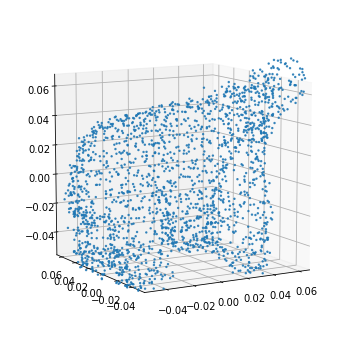

In [26]:
plot_ptcloud(predicted)

## Check Torso Length

5


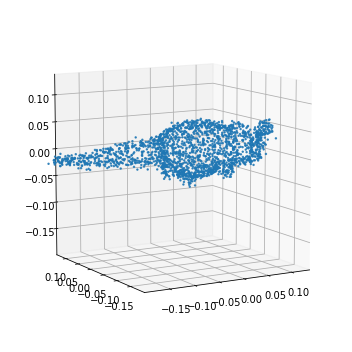

4


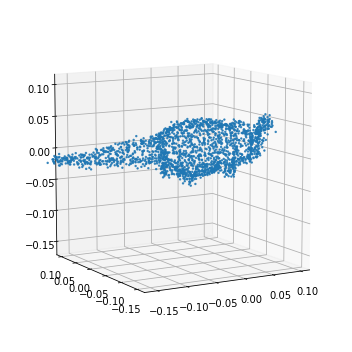

3


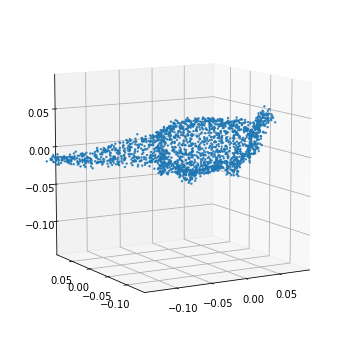

2


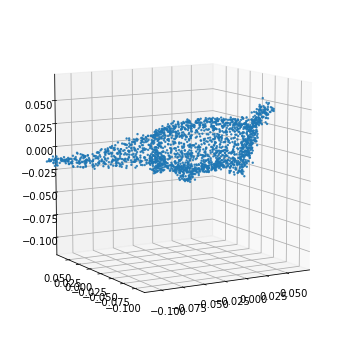

1


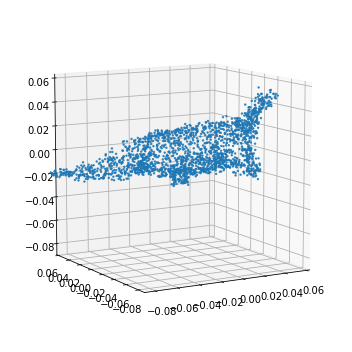

In [27]:
X_test = np.zeros((1,1,1,6))
for i in range(5,0,-1):
    print(i)
    X_test[0,0,:] = np.array([i/float(5),0.1,0,0.2,0,0.2])
    predicted = semantic_net.layers[-1].layers[-1].predict(X_test).reshape(2048,3)
    plot_ptcloud(predicted)

## Check Tail Rotation

Interestingly...the model mistakes the neck for the tail, but it does learn rotation! That's cool in my books.

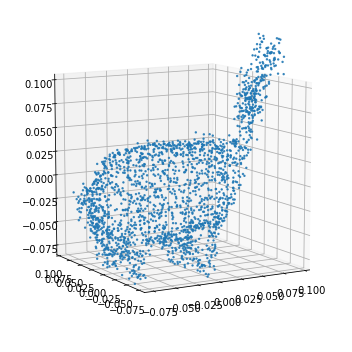

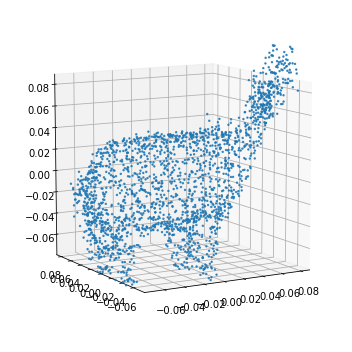

In [28]:
X_test = np.zeros((1,1,1,6))
for i in range(5,0,-1):
    X_test[0,0,:] = np.array([0.4,0.2,0.5,0,0.35,i/float(5)])
    predicted = semantic_net.layers[-1].layers[-1].predict(X_test).reshape(2048,3)
    plot_ptcloud(predicted)

You can toggle the axes to make more abstract animal shapes. 

Since I evaluated the model qualitatively by sampling in real time on a game engine, I've attached scripts for how converted the model using Python3 + keras2onnx in an iPython notebook in the `model_export_weights` folder.